In [1]:
!pip install --upgrade matplotlib

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import seed

In [3]:
from numpy.random import seed
seed(0)
import tensorflow as tf
tf.random.set_seed(0)

In [4]:
btc_stocks = pd.read_csv('btcStocks.csv')
eth_stocks = pd.read_csv('ethStocks.csv')
ada_stocks = pd.read_csv('adaStocks.csv')

btc_new_stocks = pd.read_csv('btcActualStocks.csv')
eth_new_stocks = pd.read_csv('ethActualStocks.csv')
ada_new_stocks = pd.read_csv('adaActualStocks.csv')

In [5]:
btc_stocks_close = btc_stocks.close
btc_stocks_close = btc_stocks_close.to_frame()
btc_stocks_close.head()

,close
0,457.334015
1,424.440002
2,394.795990
3,408.903992
4,398.821014


In [6]:
btc_new_stocks_close = btc_new_stocks.close
btc_new_stocks_close = btc_new_stocks_close.to_frame()
btc_new_stocks_close.head()

,close
0,32702.025391
1,32822.347656
2,31780.730469
3,31421.539063
4,31533.068359


In [7]:
eth_stocks_close = eth_stocks.close
eth_stocks_close = eth_stocks_close.to_frame()
eth_stocks_close.head()

,close
0,2.772120
1,0.753325
2,0.701897
3,0.708448
4,1.067860


In [8]:
eth_new_stocks_close = eth_new_stocks.close
eth_new_stocks_close = eth_new_stocks_close.to_frame()
eth_new_stocks_close.head()

,close
0,1940.083984
1,1994.331299
2,1911.175659
3,1880.382935
4,1898.825195


In [9]:
ada_stocks_close = ada_stocks.close
ada_stocks_close = ada_stocks_close.to_frame()
ada_stocks_close.head()

,close
0,0.024969
1,0.025932
2,0.020816
3,0.021931
4,0.021489


In [10]:
ada_new_stocks_close = ada_new_stocks.close
ada_new_stocks_close = ada_new_stocks_close.to_frame()
ada_new_stocks_close.head()

,close
0,1.265083
1,1.262258
2,1.223192
3,1.173715
4,1.172302


In [11]:
import seaborn as sns
from sklearn.metrics import mean_squared_error

def build_prediction_dataframe(training_ts, predictions_ts):
  last_training_predictions = [training_ts.tail(1), predictions_ts]
  last_training_predictions_ts = pd.concat(last_training_predictions)
  last_training_predictions_df = last_training_predictions_ts.reset_index()
  last_training_predictions_df['positive_delta'] = last_training_predictions_df.apply(lambda row: row.name > 0 and last_training_predictions_df.loc[row.name-1, :]['close'] < row['close'], axis=1)
  predictions_df = last_training_predictions_df.iloc[1: , :][['positive_delta']]
  return predictions_df

def add_row_confusion_matrix(list_of_cm, df_row):
  row = 0
  column = 0
  if df_row.positive_delta_predict:
    column = 1
  if df_row.positive_delta_actual:
    row = 1
  list_of_cm[df_row.name-1][row, column] += 1
  return list_of_cm

def evaluate(model, train_ts, test_ts, n_evaluations=10, n_test=3, n_steps=1, n_epochs=100, batch_size=16, full_test=True):
  total_hits = 0
  total_tries = 0
  confusion_matrix = [np.zeros((2,2)), np.zeros((2,2)), np.zeros((2,2))]
  print('Training on train_ts')
  # This line is to replicate the other script

  model.train(train_ts, n_epochs, batch_size)

  print('Iteration 1 started on test')
  steps_to_predict = test_ts[:n_steps]
  steps_result = test_ts[n_steps:n_steps+n_test]
  if full_test:
    i=1
    while n_steps + (n_test * i) < len(test_ts):
      print(steps_to_predict)
      predictions = model.predict(steps_to_predict)
      predictions = predictions.reshape(predictions.shape[1])
      predictions_ts = pd.DataFrame({'close': predictions}, steps_result.index)
      print(predictions_ts)

      predictions_df = build_prediction_dataframe(steps_to_predict, predictions_ts)
      predictions_df.rename(columns={'positive_delta': 'positive_delta_predict'}, inplace=True)

      test_df = build_prediction_dataframe(steps_to_predict, steps_result)
      test_df.rename(columns={'positive_delta': 'positive_delta_actual'}, inplace=True)

      predictions_and_test = pd.concat([test_df, predictions_df], axis=1)
      predictions_and_test['equal'] = predictions_and_test.apply(lambda row: row['positive_delta_actual'] == row['positive_delta_predict'], axis=1)
      predictions_and_test.apply(lambda row: add_row_confusion_matrix(confusion_matrix, row), axis=1)

      hits = predictions_and_test['equal'].sum()
      print('Accuracy: {}/{}'.format(hits, predictions_and_test.shape[0]))
      total_hits += hits
      total_tries += predictions_and_test.shape[0]

      print('Iteration {} started'.format(i))
      new_train = pd.concat([steps_to_predict, steps_result])
      model.train(new_train, epochs=1, batch_size=len(new_train), validation_split=0)
      steps_to_predict = test_ts[(n_test * (i-1)):n_steps + (n_test * (i-1))]
      steps_result = test_ts[n_steps + (n_test * (i-1)):n_steps + (n_test * i)]
      i+=1
  else:
    for i in reversed(range(1, n_evaluations + 1)):
      print('Last training {} {}'.format(i, steps_to_predict))
      predictions = model.predict(steps_to_predict)
      predictions = predictions.reshape(predictions.shape[1])
      predictions_ts = pd.DataFrame({'close': predictions}, test_evaluate.index)
      
      predictions_df = build_prediction_dataframe(steps_to_predict, predictions_ts)
      predictions_df.rename(columns={'positive_delta': 'positive_delta_predict'}, inplace=True)
      
      test_df = build_prediction_dataframe(steps_to_predict, steps_result)
      test_df.rename(columns={'positive_delta': 'positive_delta_actual'}, inplace=True)

      predictions_and_test = pd.concat([test_df, predictions_df], axis=1)
      predictions_and_test['equal'] = predictions_and_test.apply(lambda row: row['positive_delta_actual'] == row['positive_delta_predict'], axis=1)
      predictions_and_test.apply(lambda row: add_row_confusion_matrix(confusion_matrix, row), axis=1)

      hits = predictions_and_test['equal'].sum()
      print('Accuracy: {}/{}'.format(hits, predictions_and_test.shape[0]))
      total_hits += hits
      total_tries += predictions_and_test.shape[0]

      print('Iteration {} started'.format(n_evaluations + 1 - i))
      new_train = pd.concat([steps_to_predict, test_evaluate])
      model.retrain(new_train, epochs=1, batch_size=len(new_train), validation_split=0)
      steps_to_predict = new_train[-n_steps:]

  print('Total hits: {}. Total tries: {}. Accuracy: {:0.2f}'.format(total_hits, total_tries, total_hits / total_tries))
  
  return confusion_matrix

In [12]:
def plot_confusion_matrix(confusion_matrix):
  fig, axs = plt.subplots(2, 2)
  fig.supxlabel('Predicted')
  fig.supylabel('Actual')
  for i in range(0, len(confusion_matrix)):
    ax = axs[int(i/2), i%2]
    ax.title.set_text('Index {}'.format(i+1))
    sns.heatmap(data=confusion_matrix[i], annot=True, cbar=False, ax=ax)
  sum_cm = sum(confusion_matrix)
  axs[1,1].title.set_text('Total')
  sns.heatmap(data=sum_cm, annot=True, cbar=False, ax=axs[1,1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                3840      
_________________________________________________________________
dense (Dense)                (None, 2)                 62        
Total params: 3,902
Trainable params: 3,902
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/70
140/140 [==============================] - 2s 7ms/step - loss: 0.0016 - accuracy: 0.5255 - val_loss: 0.0056 - val_accuracy: 0.5301
Epoch 2/70
140/140 [==============================] - 1s 4ms/step - loss: 6.1606e-05 - accuracy: 0.5027 - val_loss: 0.0052 - val_accuracy: 0.5301
Epoch 3/70
140/140 [==============================] - 1s 4ms/step - loss: 6.0187e-05 - accuracy: 0.5022 - val_loss: 0.0061 - val_accuracy: 0.5261
Epoch 4/70
140/140 [==============================] - 1s

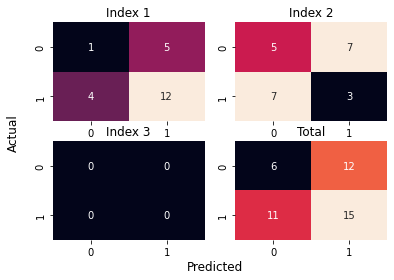

In [13]:
from VanillaLSTM import VanillaLSTM
from StackedLSTM import StackedLSTM
from BidirectionalLSTM import BidirectionalLSTM
from ConvLSTM import ConvLSTM
from CnnLSTM import CnnLSTM

epochs = 70
batch_size = 16
n_steps = 5
n_outputs = 2
n_evaluations = 10
n_neurons = 30
n_seed = 0
optimizer = 'adam'
loss = 'mean_squared_error'
model_type = VanillaLSTM

seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, btc_stocks_close, btc_new_stocks_close, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 62        
Total params: 3,902
Trainable params: 3,902
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/70
140/140 [==============================] - 2s 6ms/step - loss: 0.0016 - accuracy: 0.5255 - val_loss: 0.0056 - val_accuracy: 0.5301
Epoch 2/70
140/140 [==============================] - 1s 4ms/step - loss: 6.1606e-05 - accuracy: 0.5027 - val_loss: 0.0052 - val_accuracy: 0.5301
Epoch 3/70
140/140 [==============================] - 1s 4ms/step - loss: 6.0187e-05 - accuracy: 0.5022 - val_loss: 0.0061 - val_accuracy: 0.5261
Epoch 4/70
140/140 [==============================] - 

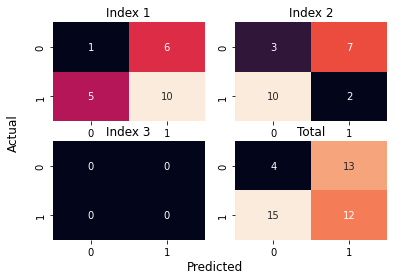

In [14]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, btc_stocks_close, eth_new_stocks_close, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 62        
Total params: 3,902
Trainable params: 3,902
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/70
140/140 [==============================] - 2s 6ms/step - loss: 0.0016 - accuracy: 0.5255 - val_loss: 0.0056 - val_accuracy: 0.5301
Epoch 2/70
140/140 [==============================] - 1s 4ms/step - loss: 6.1606e-05 - accuracy: 0.5027 - val_loss: 0.0052 - val_accuracy: 0.5301
Epoch 3/70
140/140 [==============================] - 1s 4ms/step - loss: 6.0187e-05 - accuracy: 0.5022 - val_loss: 0.0061 - val_accuracy: 0.5261
Epoch 4/70
140/140 [==============================] - 

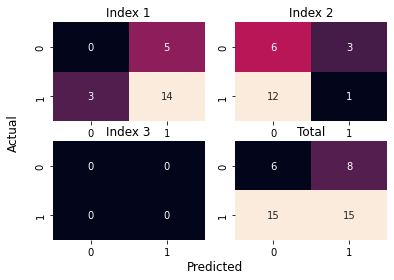

In [15]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, btc_stocks_close, ada_new_stocks_close, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 62        
Total params: 3,902
Trainable params: 3,902
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/70
122/122 [==============================] - 2s 5ms/step - loss: 0.0011 - accuracy: 0.4887 - val_loss: 0.0049 - val_accuracy: 0.5253
Epoch 2/70
122/122 [==============================] - 0s 4ms/step - loss: 7.0073e-05 - accuracy: 0.4964 - val_loss: 0.0045 - val_accuracy: 0.5300
Epoch 3/70
122/122 [==============================] - 0s 4ms/step - loss: 6.8896e-05 - accuracy: 0.5046 - val_loss: 0.0063 - val_accuracy: 0.4885
Epoch 4/70
122/122 [==============================] - 

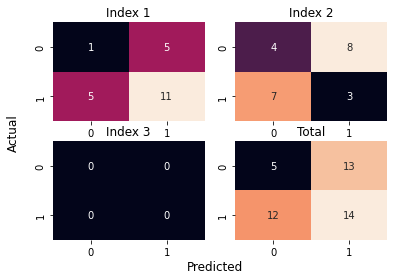

In [16]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, eth_stocks_close, btc_new_stocks_close, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 62        
Total params: 3,902
Trainable params: 3,902
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/70
122/122 [==============================] - 2s 6ms/step - loss: 0.0011 - accuracy: 0.4887 - val_loss: 0.0049 - val_accuracy: 0.5253
Epoch 2/70
122/122 [==============================] - 0s 4ms/step - loss: 7.0073e-05 - accuracy: 0.4964 - val_loss: 0.0045 - val_accuracy: 0.5300
Epoch 3/70
122/122 [==============================] - 0s 4ms/step - loss: 6.8896e-05 - accuracy: 0.5046 - val_loss: 0.0063 - val_accuracy: 0.4885
Epoch 4/70
122/122 [==============================] - 

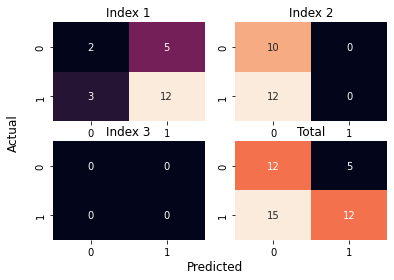

In [17]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, eth_stocks_close, eth_new_stocks_close, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 62        
Total params: 3,902
Trainable params: 3,902
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/70
122/122 [==============================] - 2s 6ms/step - loss: 0.0011 - accuracy: 0.4887 - val_loss: 0.0049 - val_accuracy: 0.5253
Epoch 2/70
122/122 [==============================] - 0s 4ms/step - loss: 7.0073e-05 - accuracy: 0.4964 - val_loss: 0.0045 - val_accuracy: 0.5300
Epoch 3/70
122/122 [==============================] - 0s 3ms/step - loss: 6.8896e-05 - accuracy: 0.5046 - val_loss: 0.0063 - val_accuracy: 0.4885
Epoch 4/70
122/122 [==============================] - 

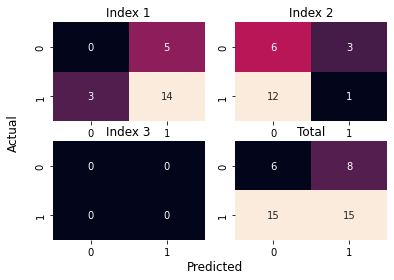

In [18]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, eth_stocks_close, ada_new_stocks_close, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 62        
Total params: 3,902
Trainable params: 3,902
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/70
78/78 [==============================] - 2s 7ms/step - loss: 0.0033 - accuracy: 0.5158 - val_loss: 0.0913 - val_accuracy: 0.4855
Epoch 2/70
78/78 [==============================] - 0s 4ms/step - loss: 7.3338e-04 - accuracy: 0.5344 - val_loss: 0.0054 - val_accuracy: 0.4855
Epoch 3/70
78/78 [==============================] - 0s 4ms/step - loss: 3.4582e-04 - accuracy: 0.4915 - val_loss: 0.0061 - val_accuracy: 0.5145
Epoch 4/70
78/78 [==============================] - 0s 4ms/s

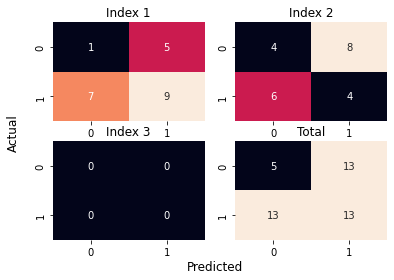

In [19]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, ada_stocks_close, btc_new_stocks_close, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 62        
Total params: 3,902
Trainable params: 3,902
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/70
78/78 [==============================] - 2s 7ms/step - loss: 0.0033 - accuracy: 0.5158 - val_loss: 0.0913 - val_accuracy: 0.4855
Epoch 2/70
78/78 [==============================] - 0s 4ms/step - loss: 7.3338e-04 - accuracy: 0.5344 - val_loss: 0.0054 - val_accuracy: 0.4855
Epoch 3/70
78/78 [==============================] - 0s 4ms/step - loss: 3.4582e-04 - accuracy: 0.4915 - val_loss: 0.0061 - val_accuracy: 0.5145
Epoch 4/70
78/78 [==============================] - 0s 4ms/s

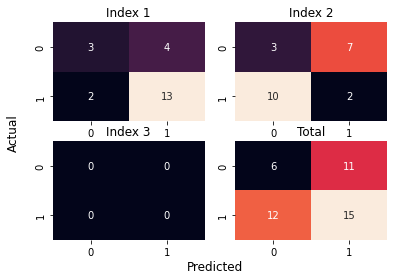

In [20]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, ada_stocks_close, eth_new_stocks_close, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 62        
Total params: 3,902
Trainable params: 3,902
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/70
78/78 [==============================] - 2s 6ms/step - loss: 0.0033 - accuracy: 0.5158 - val_loss: 0.0913 - val_accuracy: 0.4855
Epoch 2/70
78/78 [==============================] - 0s 4ms/step - loss: 7.3338e-04 - accuracy: 0.5344 - val_loss: 0.0054 - val_accuracy: 0.4855
Epoch 3/70
78/78 [==============================] - 0s 4ms/step - loss: 3.4582e-04 - accuracy: 0.4915 - val_loss: 0.0061 - val_accuracy: 0.5145
Epoch 4/70
78/78 [==============================] - 0s 4ms/s

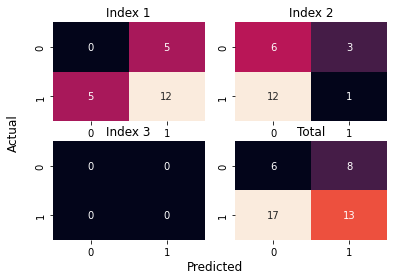

In [21]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, ada_stocks_close, ada_new_stocks_close, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)